In [13]:
import pandas as pd

df = pd.read_csv("/content/data.csv")
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [14]:
from sklearn.preprocessing import LabelEncoder


df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # male=1, female=0
df['EducationLevel'] = LabelEncoder().fit_transform(df['EducationLevel'])
df['RecruitmentStrategy'] = LabelEncoder().fit_transform(df['RecruitmentStrategy'])

X = df.drop(columns=['HiringDecision'])
y = df['HiringDecision']
sensitive_attr = df['Gender']




In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, sensitive_attr, test_size=0.2, random_state=42, stratify=y)


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       207
           1       0.80      0.70      0.75        93

    accuracy                           0.85       300
   macro avg       0.84      0.81      0.82       300
weighted avg       0.85      0.85      0.85       300



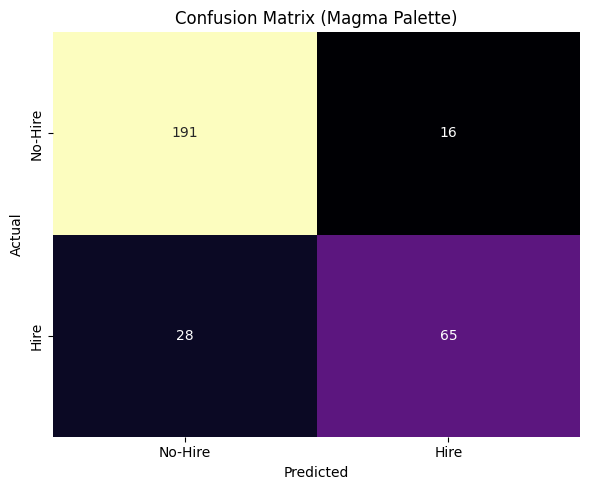

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=False,
            xticklabels=['No-Hire', 'Hire'], yticklabels=['No-Hire', 'Hire'])

plt.title('Confusion Matrix (Magma Palette)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [18]:
import numpy as np

def demographic_parity(y_pred, gender):
    p_male = np.mean(y_pred[gender == 1])
    p_female = np.mean(y_pred[gender == 0])
    return abs(p_male - p_female)

dp = demographic_parity(y_pred, gender_test.reset_index(drop=True))
print(f"Demographic Parity Difference: {dp:.3f}")


Demographic Parity Difference: 0.092


/tmp/ipython-input-19-3053562325.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='Prediction', data=hire_rates, palette='viridis')


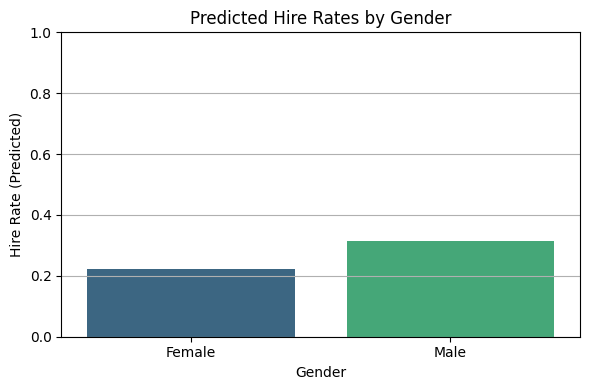

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_test_reset = gender_test.reset_index(drop=True)

df_preds = pd.DataFrame({
    'Gender': gender_test_reset,
    'Prediction': y_pred
})

df_preds['Gender'] = df_preds['Gender'].map({1: 'Male', 0: 'Female'})


hire_rates = df_preds.groupby('Gender')['Prediction'].mean().reset_index()


plt.figure(figsize=(6, 4))
sns.barplot(x='Gender', y='Prediction', data=hire_rates, palette='viridis')
plt.title('Predicted Hire Rates by Gender')
plt.ylabel('Hire Rate (Predicted)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


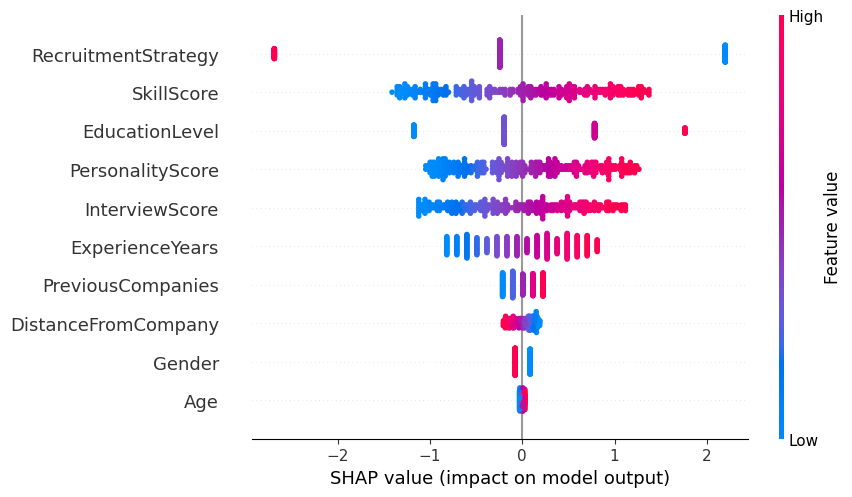

In [20]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)


In [21]:

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_label = model.predict(X_test)

hire_indices = np.where(y_pred_label == 1)[0][:3]
no_hire_indices = np.where(y_pred_label == 0)[0][:2]

explain_indices = np.concatenate([hire_indices, no_hire_indices])



Explaining index 2 - Predicted Label: 1


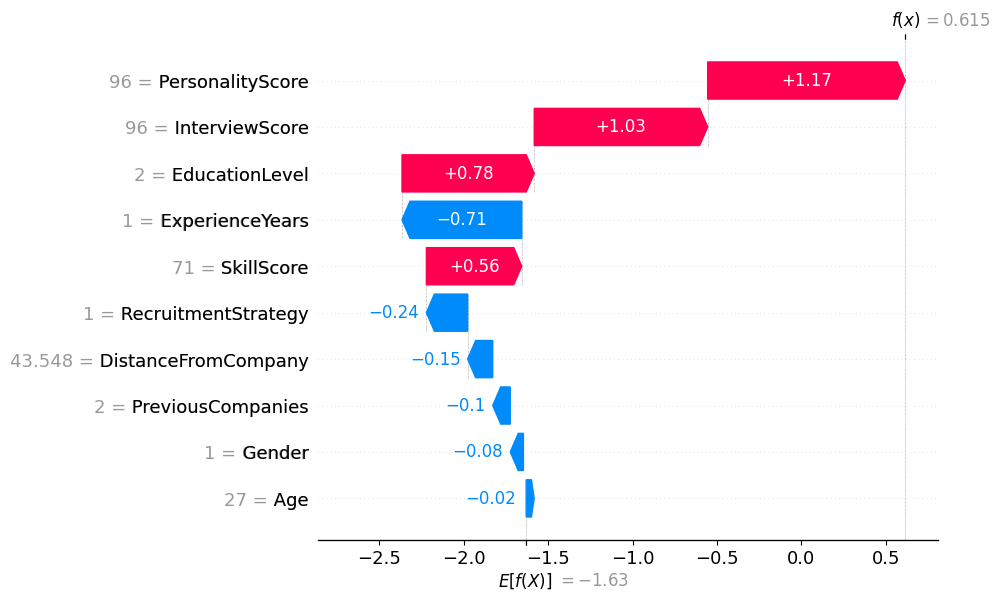


Explaining index 5 - Predicted Label: 1


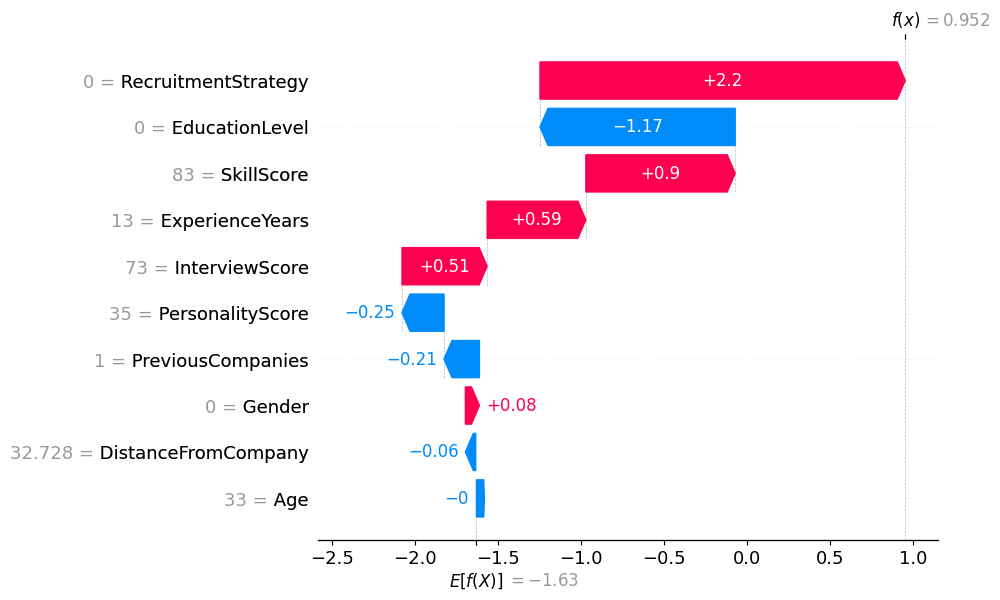


Explaining index 7 - Predicted Label: 1


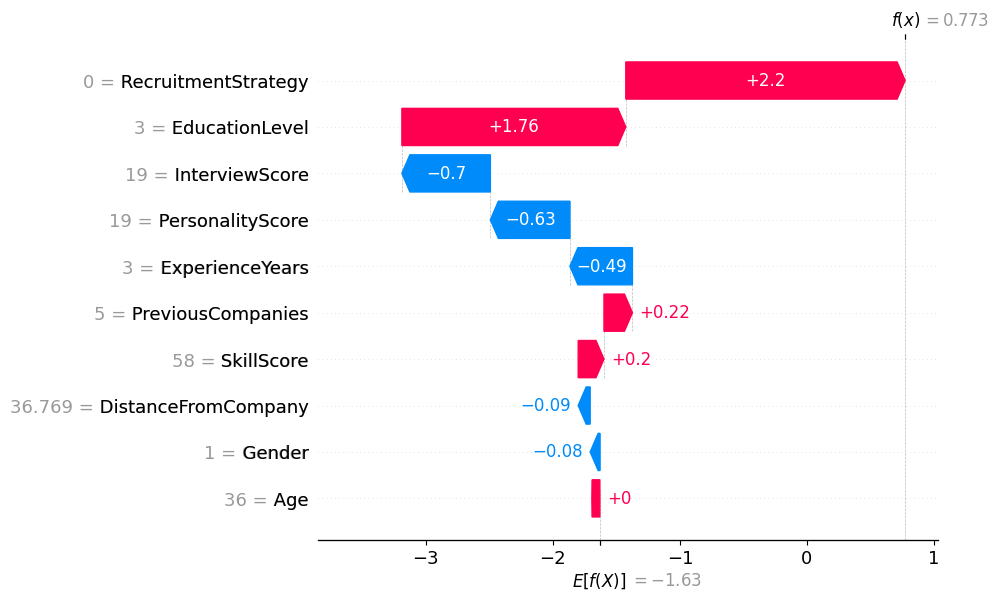


Explaining index 0 - Predicted Label: 0


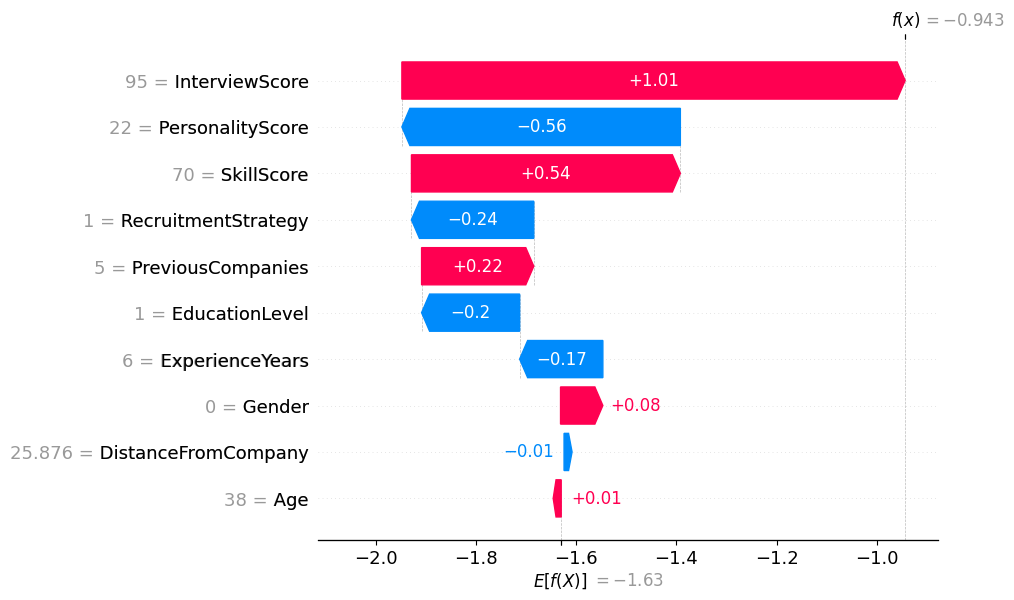


Explaining index 1 - Predicted Label: 0


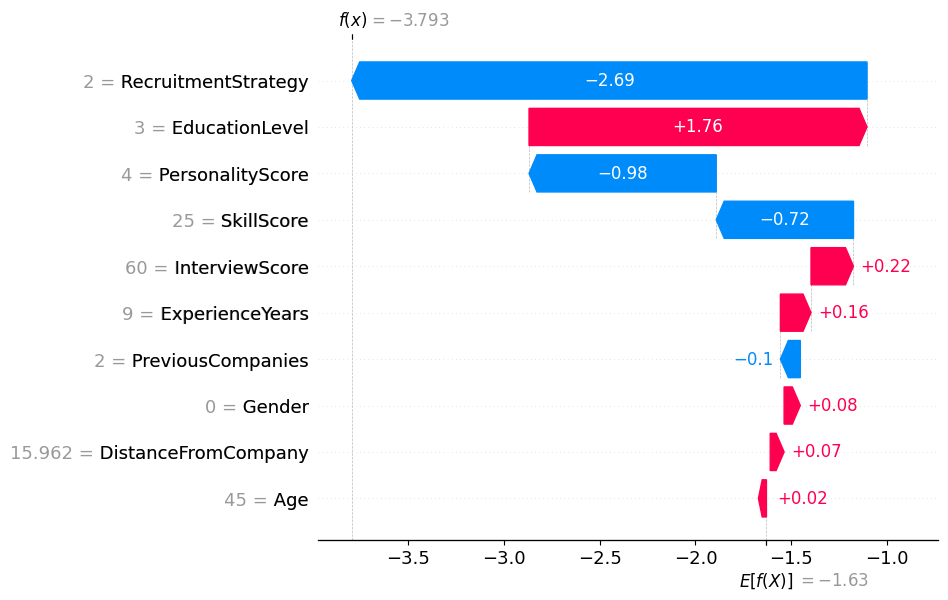

In [22]:

for i in explain_indices:
    print(f"\nExplaining index {i} - Predicted Label: {y_pred_label[i]}")
    shap.plots.waterfall(shap_values[i])


In [23]:
from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model_weighted = LogisticRegression(max_iter=1000)
model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_weighted = model_weighted.predict(X_test)
print(classification_report(y_test, y_pred_weighted))


              precision    recall  f1-score   support

           0       0.91      0.86      0.88       207
           1       0.71      0.81      0.76        93

    accuracy                           0.84       300
   macro avg       0.81      0.83      0.82       300
weighted avg       0.85      0.84      0.84       300

